In [2]:
import numpy as np
import pandas as pd
import scipy
import sklearn
from sklearn.pipeline import make_pipeline
import os

# skimage
import skimage
import skimage.color
import skimage.feature
import skimage.transform
import skimage.io

In [5]:
from sklearn.base import BaseEstimator,TransformerMixin

class rgb2gray_transfrom(BaseEstimator,TransformerMixin):
    import skimage.color
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        return np.array([skimage.color.regb2gray(x) for x in X])
    
class hogtransformer(BaseEstimator,TransformerMixin):
    import skimage.feature
    def __init__(self,orientations=10,pixels_per_cell=(8,8),cells_per_block=(2,2),):
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        def local_hog(img):
            hog_features = skimage.feature.hog(img,orientations = self.orientations,
                                              pixels_per_cell = self.pixels_per_cell ,
                                              cells_per_block = self.cells_per_block)
            
            return hog_features
        
        hfeatures = np.array([local_hog(x) for x in X])
        return hfeatures

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# pipeline model 
image = skimage.io.imread('eagle.jpg')

In [21]:
image_resize = skimage.transform.resize(image,(80,80))
image_scale = 255*image_resize
image_transform = image_scale.astype(np.uint8)
# rgb to gray
gray = skimage.color.rgb2gray(image_transform)
# hog feature
feature_vector = skimage.feature.hog(gray,orientations=10,pixels_per_cell=(8,8),cells_per_block=(2,2))


In [22]:
feature_vector

array([0.23151945, 0.0690082 , 0.25927445, ..., 0.06118128, 0.0255605 ,
       0.00889438])

In [24]:
import pickle
# load the model
model = pickle.load(open('dsa_image_classification_sgd.pickle','rb'))
scaler = pickle.load(open('dsa_scalar.pickle','rb'))

In [25]:
feature_vector.shape

(3240,)

In [26]:
model.get_params()

{'alpha': 0.001,
 'average': False,
 'class_weight': None,
 'early_stopping': True,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'squared_hinge',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [33]:
#  r =feature_vector.reshape(1,-1)

In [34]:
# r.shape

(1, 3240)

In [42]:
scalex = scaler.transform(feature_vector.reshape(1,-1))
result = model.predict(scalex)

In [43]:
result

array(['eagle'], dtype='<U8')

In [73]:
# model.predict_proba(scalex) ##probability estimates are not available for loss='squared_hinge'

In [44]:
# cal the probability
decision_value = model.decision_function(scalex)

In [45]:
decision_value

array([[-8.96294343e+14, -9.54538008e+14, -9.48524286e+14,
        -1.08547883e+15, -1.66611605e+15, -1.11547545e+15,
        -2.81852050e+14, -1.21348817e+14, -1.46367552e+15,
        -1.08967729e+15, -1.74475963e+15, -2.99995803e+14,
        -1.77451716e+15, -1.31045242e+15, -8.31020630e+14,
        -5.96571318e+14, -8.52775898e+14, -8.09587837e+14,
        -8.45441864e+14, -2.03269990e+15]])

In [48]:
labels = model.classes_

In [50]:
decision_value = decision_value.flatten()


<BarContainer object of 20 artists>

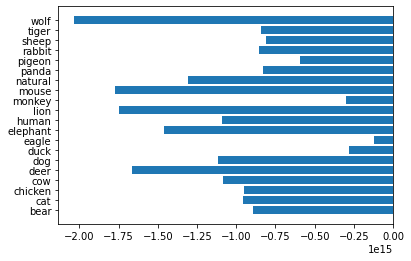

In [51]:
plt.barh(labels,decision_value)

In [52]:
# calculate z score
z = scipy.stats.zscore(decision_value)
z

array([ 0.27823752,  0.16227288,  0.17424635, -0.09843367, -1.25449737,
       -0.15815771,  1.50160798,  1.82117405, -0.85143304, -0.10679291,
       -1.41107877,  1.4654833 , -1.47032678, -0.54636189,  0.40819916,
        0.87499379,  0.36488386,  0.45087241,  0.37948611, -1.98437526])

In [53]:
prob_value = scipy.special.softmax(z)
prob_value

array([0.04177042, 0.03719684, 0.03764489, 0.02866043, 0.00902008,
       0.02699882, 0.14196193, 0.19541491, 0.01349768, 0.02842185,
       0.00771273, 0.13692513, 0.00726904, 0.0183126 , 0.04756752,
       0.07586419, 0.0455511 , 0.04964131, 0.04622113, 0.00434739])

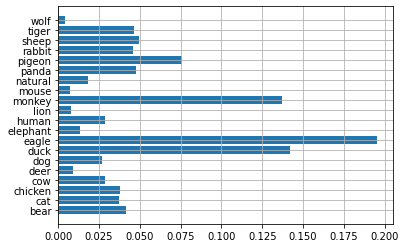

In [54]:
plt.barh(labels,prob_value)
plt.grid()

In [62]:
prob_value.argsort()

array([19, 12, 10,  4,  8, 13,  5,  9,  3,  1,  2,  0, 16, 18, 14, 17, 15,
       11,  6,  7], dtype=int64)

In [69]:
top_5_prob_ind = prob_value.argsort()[::-1][:5]
top_5_prob_ind

array([ 7,  6, 11, 15, 17], dtype=int64)

In [67]:
top_labels = labels[top_5_prob_ind]
top_prob = prob_value[top_5_prob_ind]

In [68]:
top_prob,top_labels

(array([0.19541491, 0.14196193, 0.13692513, 0.07586419, 0.04964131]),
 array(['eagle', 'duck', 'monkey', 'pigeon', 'sheep'], dtype='<U8'))

In [70]:
top_dict = dict()
for key,val in zip(top_labels,top_prob):
    top_dict.update({key:np.round(val,3)})

In [71]:
top_dict

{'eagle': 0.195,
 'duck': 0.142,
 'monkey': 0.137,
 'pigeon': 0.076,
 'sheep': 0.05}

In [74]:
def pipeline_model(path,scaler_transform,model_sgd):
    # pipeline model
    image = skimage.io.imread(path)
    # transform image into 80 x 80
    image_resize = skimage.transform.resize(image,(80,80))
    image_scale = 255*image_resize
    image_transform = image_scale.astype(np.uint8)
    # rgb to gray
    gray = skimage.color.rgb2gray(image_transform)
    # hog feature
    feature_vector = skimage.feature.hog(gray,
                                  orientations=10,
                                  pixels_per_cell=(8,8),cells_per_block=(2,2))
    
    # scaling
    scalex = scaler_transform.transform(feature_vector.reshape(1,-1))
    result = model_sgd.predict(scalex)   
        
    # decision function # confidence   
    decision_value = model_sgd.decision_function(scalex).flatten()
    labels = model_sgd.classes_
    
    # probability
    z = scipy.stats.zscore(decision_value)
    prob_value = scipy.special.softmax(z)
    
    
    # top 5
    top_5_prob_ind = prob_value.argsort()[::-1][:5]
    top_labels = labels[top_5_prob_ind]
    top_prob = prob_value[top_5_prob_ind]
    # put in dictornary
    top_dict = dict()
    for key,val in zip(top_labels,top_prob):
        top_dict.update({key:np.round(val,3)})
    
    return top_dict
    

In [76]:
res = pipeline_model('eagle.jpg',scaler,model)
res

{'eagle': 0.189,
 'duck': 0.142,
 'monkey': 0.138,
 'pigeon': 0.075,
 'sheep': 0.052}